# INITIALIZE

## 필요 모듈 import

In [16]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MalNetTiny
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.transforms import LocalDegreeProfile

## GPU 사용 확인

In [17]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
if torch.cuda.is_available():
    print("GPU 사용중")
    divice = torch.device("cuda")
else:
    print("CPU 사용 불가능")
    divice = torch.device("cpu")

2.0.1
GPU 사용중


## Hyperparameter 설정

In [18]:
HyperParams = { # data 관련
                "data_root": "./data",
                "data_transform": LocalDegreeProfile(),
                "random_seed": 42,
                "data_split": {"train":0.8, "val":0.1, "test":0.1},
                "batch_size": 128,
                
                # model 관련
                "num_layers": 6,
                "hidden_dim": 64,
                "dropout": 0,     # (dropout 안쓰면 0)
                
                # train 관련
                "Optimizer": torch.optim.Adam,
                "learning_rate": 0.001,
                "loss_fn": torch.nn.CrossEntropyLoss(),
                "epochs": 200
}

# DATASET

## Dateset 불러오기

In [19]:
dataset = MalNetTiny(root=HyperParams["data_root"], transform=HyperParams["data_transform"])

## Dataset 정보 확인

In [20]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('=============================================================')
data = dataset[0]
print(data)
print()


Dataset: MalNetTiny(5000):
Number of graphs: 5000
Number of features: 5
Number of classes: 5
Data(edge_index=[2, 3576], y=[1], num_nodes=1679, x=[1679, 5])



## Dataset 분할

In [21]:
torch.manual_seed(HyperParams["random_seed"])
dataset = dataset.shuffle()
num_train = int(len(dataset)*HyperParams["data_split"]["train"])
num_val = int(len(dataset)*HyperParams["data_split"]["val"])

train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_train+num_val]
test_dataset = dataset[num_train+num_val:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing graphs: {len(test_dataset)}')

Number of training graphs: 4000
Number of validation graphs: 500
Number of testing graphs: 500


## Dataset DataLoader에 넣기

In [22]:
train_loader = DataLoader(train_dataset, batch_size=HyperParams["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HyperParams["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HyperParams["batch_size"], shuffle=False)

# MODEL

## Model class 정의

In [23]:
class GIN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim, dropout):
        super(GIN, self).__init__()
        self.args = {"num_layers":num_layers,
                    "hidden_dim":hidden_dim,
                    "dropout":dropout,
                    "num_classes":dataset.num_classes,
                    "num_features":dataset.num_features}
        
        self.layers = torch.nn.ModuleList([])
        for i in range(self.args["num_layers"]):
            if i == 0:
                self.layers.append(GINConv(Sequential(Linear(self.args["num_features"], self.args["hidden_dim"]), ReLU(), BN(self.args["hidden_dim"])), train_eps=True))
            else:
                self.layers.append(GINConv(Sequential(Linear(self.args["hidden_dim"], self.args["hidden_dim"]), ReLU(), BN(self.args["hidden_dim"])), train_eps=True))
        
        self.fc1 = Linear(self.args["hidden_dim"], self.args["hidden_dim"])
        self.fc2 = Linear(self.args["hidden_dim"], self.args["num_classes"])
    
    def forward(self, x, edge_index, batch):
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            x = F.relu(x)
        x = global_add_pool(x, batch)
        
        x = F.relu(self.fc1(x))
        if self.args["dropout"] > 0:
            x = F.dropout(x, p=self.args["dropout"], training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Model 생성

In [24]:
model = GIN(num_layers=HyperParams["num_layers"],
            hidden_dim=HyperParams["hidden_dim"],
            dropout=HyperParams["dropout"]).to(divice)
print(model)

GIN(
  (layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
    (1-5): 5 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    ))
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)


# TRAIN

## optim, loss fn 정의

In [25]:
optimizer = HyperParams["Optimizer"](model.parameters(), lr=HyperParams["learning_rate"])
loss_fn = HyperParams["loss_fn"]

## Train 함수 정의

In [26]:
def train():
    model.train()
    
    loss_total = 0
    y_true, y_pred = [], []
    for data in train_loader:
        data = data.to(divice)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        pred = out.max(dim=1)[1]
        
        y_true.append(data.y.detach().cpu().numpy().tolist())
        y_pred.append(pred.detach().cpu().numpy().tolist())
        
        loss = loss_fn(out, data.y)
        loss.backward()
        loss_total += loss.item() * data.num_graphs
        optimizer.step()
    
    y_true = [y for x in y_true for y in x]
    y_pred = [y for x in y_pred for y in x]
    acc = accuracy_score(y_true, y_pred)
    return loss_total / len(train_dataset), acc

## Test 함수 정의

In [27]:
def test(loader):
    model.eval()
    
    loss_total = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(divice)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.max(dim=1)[1]
        
        y_true.append(data.y.detach().cpu().numpy().tolist())
        y_pred.append(pred.detach().cpu().numpy().tolist())
        
        loss = loss_fn(out, data.y)
        loss_total += loss.item() * data.num_graphs
    
    y_true = [y for x in y_true for y in x]
    y_pred = [y for x in y_pred for y in x]
    acc = accuracy_score(y_true, y_pred)
    return loss_total / len(loader.dataset), acc

## 학습 실행

In [28]:
results = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "test_loss":0, "test_acc":0}

for epoch in range(HyperParams["epochs"]):
    train_loss, train_acc = train()
    val_loss, val_acc = test(val_loader)
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\t\t', end="\r")

## 학습 결과 출력

Test Loss: 0.3013, Test Acc: 0.9160
Best Val Acc: 0.9220 at epoch 186


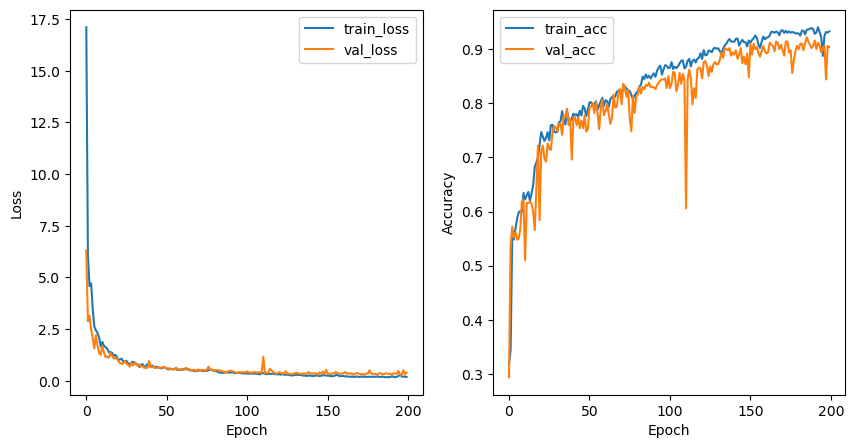

In [29]:
test_loss, test_acc = test(test_loader)
results["test_loss"] = test_loss
results["test_acc"] = test_acc

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
print(f'Best Val Acc: {max(results["val_acc"]):.4f} at epoch {results["val_acc"].index(max(results["val_acc"]))+1}')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results["train_acc"], label="train_acc")
plt.plot(results["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 모델 저장

In [30]:
file_name = f"./saves/GIN_{str(int(results['test_acc']*1000))}_{HyperParams['num_layers']}_{HyperParams['hidden_dim']}_{HyperParams['dropout']}_{HyperParams['learning_rate']}_{HyperParams['epochs']}.pt"
torch.save(model.state_dict(), file_name)
print(f"saved at {file_name}")

saved at ./saves/GIN_916_6_64_0_0.001_200.pt
